# Imports

In [1]:
import os
import wandb
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoModelForCausalLM, GPT2Tokenizer
from datasets import load_dataset
from huggingface_hub import login
from trl import DPOTrainer, DPOConfig

# wandb login

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: st125051 (st125051-ait) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Huggingface login

In [ ]:
removing this for security purpose

# Importing Dataset

In [4]:
dataset = load_dataset("Anthropic/hh-rlhf", split="train[:5]")
print(dataset)
print(dataset[:5])

Dataset({
    features: ['chosen', 'rejected'],
    num_rows: 5
})
{'chosen': ["\n\nHuman: What are some cuss words in english?\n\nAssistant: Here’s an incomplete list.\n\nAss, dick, bugger, crap, fuck, shit, bitch, turd, shithead, shitbag, scrotum, cunt, whore, fucker, shit-eating, cum, cumbucket, fucknugget, butthole, poop, jackass, cocksucker, asshole, goddamn, piss, sperm, blow, wank, jism, cum-sucking, masturbate, faggot, queer, jizz, jizz-licking, prostitute, slut, cheater, fornicator, floozy, wetback, Mexican, Hispanic, sodomite, midget, mama’s boy, faggot, pervert, queer, scumbag, bitch,\n\nHuman: What's your favorite one?\n\nAssistant: I haven't even thought about it.", '\n\nHuman: What kind of noises did dinosaurs make?\n\nAssistant: Humans and dinosaurs didn’t live at the same time, so it’s really hard to say. The best place to find out what noises dinosaurs made would be\n\nHuman: yes they did\n\nAssistant: to guess, and that would probably require lots of reading and a cer

# Load Tokenizer


In [5]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load Pretrain Model 

In [6]:
model = AutoModelForCausalLM.from_pretrained("gpt2").to("mps")

# Preprocessing

In [7]:
def transform_data(samples):
    rejected_tokens = tokenizer(
        samples['rejected'], truncation=True, padding='max_length', max_length=512
    )
    chosen_tokens = tokenizer(
        samples['chosen'], truncation=True, padding='max_length', max_length=512
    )
    return {
        'chosen_input_ids': chosen_tokens['input_ids'],
        'rejected_input_ids': rejected_tokens['input_ids'],
        'chosen_attention_mask': chosen_tokens['attention_mask'],
        'rejected_attention_mask': rejected_tokens['attention_mask'],
    }

# Dataset Splitting

In [8]:
updated_dataset = dataset.map(transform_data, batched=True)

split_data = updated_dataset.train_test_split(test_size=0.2)
training_set = split_data["train"]
validation_set = split_data["test"]

# Hyperparameters

In [9]:
hyper_parameters = [
    {"lr": 3e-5, "batch": 3, "decay": 0.1},
    {"lr": 2e-4, "batch": 2, "decay": 0.01},
    {"lr": 1e-5, "batch": 1, "decay": 0.005}
]

# WandB Initialization

In [ ]:
def initialize_wandb_run(config):
    """Initializes a new W&B run with the given hyperparameters."""
    return wandb.init(
        project="dpo-gpt2-tuning",
        config={
            "model": "gpt2",
            "dataset": "Anthropic/hh-rlhf",
            "learning_rate": config["lr"],
            "batch_size": config["batch"],
            "weight_decay": config["decay"],
            "warmup_ratio": 0.1,
            "epochs": 2
        },
        name=f"lr-{config['lr']}_bs-{config['batch']}_ep-1",
        reinit=True
    )

# Directory Creation

In [ ]:
def create_output_directory(config):
    """Creates the output directory for results."""
    output_dir = f"./results/{config['lr']}_{config['batch']}"
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

# Training Configuration

In [ ]:
def create_training_config(config, output_dir):
    """Creates the training configuration for the DPOTrainer."""
    return DPOConfig(
        output_dir=output_dir,
        do_eval=True, 
        eval_strategy="epoch",
        warmup_ratio=0.1,
        save_strategy="epoch",
        logging_strategy="epoch",
        logging_steps=10,  
        per_device_train_batch_size=config["batch"],
        per_device_eval_batch_size=config["batch"],
        num_train_epochs=2,
        learning_rate=config["lr"],
        weight_decay=config["decay"],
        logging_dir="./logs",
        fp16=False,  # todo
        report_to="wandb"
    )

# Trainer Initialization

In [ ]:
def initialize_trainer(training_config, model, training_set, validation_set, tokenizer):
    """Initializes the DPOTrainer with the given configurations."""
    return DPOTrainer(
        model=model,
        args=training_config,
        train_dataset=training_set,
        eval_dataset=validation_set,
        processing_class=tokenizer
    )

# Model Training

In [ ]:
def train_model(trainer, config):
    """Trains the model and prints progress."""
    print(f"Starting training with LR: {config['lr']}, Batch Size: {config['batch']}")
    trainer.train()
    print("Training completed successfully!")

# Model Evaluation

In [ ]:
def evaluate_model(trainer):
    """Evaluates the model and logs the evaluation results."""
    print("Starting evaluation...")
    evaluation_results = trainer.evaluate()
    evaluation_loss = evaluation_results["eval_loss"]
    print(f"Evaluation Loss: {evaluation_loss}")
    wandb.log({"final_eval_loss": evaluation_loss})
    return evaluation_loss

# Model Update









In [ ]:
def update_best_model(evaluation_loss, lowest_loss, model):
    """Updates the best model if the evaluation loss is lower than the previous."""
    if evaluation_loss < lowest_loss:
        lowest_loss = evaluation_loss
        optimal_model = model
        return optimal_model, lowest_loss
    return None, lowest_loss

# Result Logging










In [ ]:
def store_experiment_results(config, evaluation_loss, wandb_run):
    """Stores the results of the experiment."""
    return {
        "learning_rate": config["lr"],
        "batch_size": config["batch"],
        "epochs": 2, 
        "weight_decay": config["decay"],
        "eval_loss": evaluation_loss,
        "run_id": wandb_run.id
    }

# Experiment

In [11]:
optimal_model = None
lowest_loss = float("inf")
experiment_results = []

for config in hyper_parameters:
    wandb_run = initialize_wandb_run(config) # Initialize W&B run
    output_dir = create_output_directory(config) # Create output directory
    training_config = create_training_config(config, output_dir) # Create training configuration
    trainer = initialize_trainer(training_config, model, training_set, validation_set, tokenizer) # Initialize Trainer
    train_model(trainer, config) # Train model
    evaluation_loss = evaluate_model(trainer) # Evaluate model
    # Update best model if applicable
    optimal_model, lowest_loss = update_best_model(evaluation_loss, lowest_loss, model)
    if optimal_model:
        wandb_run.summary["best_model"] = True 

    experiment_results.append(store_experiment_results(config, evaluation_loss, wandb_run)) # Store experiment results
    wandb.finish() # Finish W&B run

print("All experiments completed!")

Starting training with LR: 3e-05, Batch Size: 3


Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
1,0.693100,0.596245,-0.015334,-0.219545,1.000000,0.204211,-19.447723,-48.665462,-128.877762,-146.916580
2,0.064900,0.493045,-0.064027,-0.514551,1.000000,0.450524,-19.934656,-51.615524,-120.789124,-147.199493


Training completed successfully!
Starting evaluation...


Evaluation Loss: 0.49304506182670593


eval/logits/chosen,▁██
eval/logits/rejected,█▁▁
eval/logps/chosen,█▁▁
eval/logps/rejected,█▁▁
eval/loss,█▁▁
eval/rewards/accuracies,▁▁▁
eval/rewards/chosen,█▁▁
eval/rewards/margins,▁██
eval/rewards/rejected,█▁▁
eval/runtime,▁▇█
eval/samples_per_second,█▁▁


Starting training with LR: 0.0002, Batch Size: 2


Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
1,0.693100,0.018072,-3.364460,-7.368784,1.000000,4.004324,-53.579254,-125.303368,-52.954231,-120.732803
2,1.486200,0.036379,-3.316030,-6.611537,1.000000,3.295507,-53.094955,-117.730896,20.120754,-70.628723


Training completed successfully!
Starting evaluation...


Evaluation Loss: 0.03637946397066116


eval/logits/chosen,▁██
eval/logits/rejected,▁██
eval/logps/chosen,▁██
eval/logps/rejected,▁██
eval/loss,▁██
eval/rewards/accuracies,▁▁▁
eval/rewards/chosen,▁██
eval/rewards/margins,█▁▁
eval/rewards/rejected,▁██
eval/runtime,▃█▁
eval/samples_per_second,▅▁█


Starting training with LR: 1e-05, Batch Size: 1


Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
1,0.529500,0.730432,0.181145,0.254375,0.000000,-0.073230,-51.283508,-115.187149,15.908402,-81.029289
2,0.043600,0.828101,0.121961,0.375803,0.000000,-0.253841,-51.875343,-113.972870,11.524031,-84.134094


Training completed successfully!
Starting evaluation...


Evaluation Loss: 0.8281007409095764


eval/logits/chosen,█▁▁
eval/logits/rejected,█▁▁
eval/logps/chosen,█▁▁
eval/logps/rejected,▁██
eval/loss,▁██
eval/rewards/accuracies,▁▁▁
eval/rewards/chosen,█▁▁
eval/rewards/margins,█▁▁
eval/rewards/rejected,▁██
eval/runtime,▁▄█
eval/samples_per_second,█▃▁


All experiments completed!


# Experiment Summary









In [14]:
experiment_summary = wandb.Table(
    columns=["Run ID", "Learning Rate", "Batch Size", "Epochs", "Eval Loss", "Weight Decay", "Is Best"]
)

for exp_result in experiment_results:
    experiment_summary.add_data(
        exp_result["run_id"],
        exp_result["learning_rate"],
        exp_result["batch_size"],
        exp_result["epochs"],
        exp_result["eval_loss"],
        exp_result["weight_decay"],
        exp_result["eval_loss"] == lowest_loss 
    )

summary_run = wandb.init(project="dpo-gpt2-tuning", name="hyperparameter-summary")
wandb.log({"results_summary": experiment_summary})

summary_log_run = wandb.init(project="dpo-gpt2-tuning", name="hyperparameter-overview")
wandb.log({"final_results_summary": experiment_summary})

hyperparam_summary_run = wandb.init(project="dpo-gpt2-tuning", name="hyperparameter-results")
wandb.log({"summary_of_results": experiment_summary})

# Saving Model

In [18]:
optimized_model_path = f"./optimized_model/eval_loss-{lowest_loss}"
optimal_model.save_pretrained(optimized_model_path)
tokenizer.save_pretrained(optimized_model_path)

('./optimized_model/eval_loss-0.005636631045490503/tokenizer_config.json',
 './optimized_model/eval_loss-0.005636631045490503/special_tokens_map.json',
 './optimized_model/eval_loss-0.005636631045490503/vocab.json',
 './optimized_model/eval_loss-0.005636631045490503/merges.txt',
 './optimized_model/eval_loss-0.005636631045490503/added_tokens.json')

# Uploading Model

In [21]:
optimal_model.push_to_hub("UsmanTara/dpo_model")
tokenizer.push_to_hub("UsmanTara/dpo_model")
wandb.finish()

wandb-core(11961) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

wandb-core(11977) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(11987) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(12040) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(12067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(12083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(12125) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

In [22]:
results_df = pd.DataFrame(experiment_results)
results_df

,learning_rate,batch_size,epochs,weight_decay,eval_loss,run_id
0,0.00003,3,2,0.100,0.589527,tdw43i9m
1,0.00020,2,2,0.010,0.005637,ic65d3mg
2,0.00001,1,2,0.005,0.462602,6bgfssrx


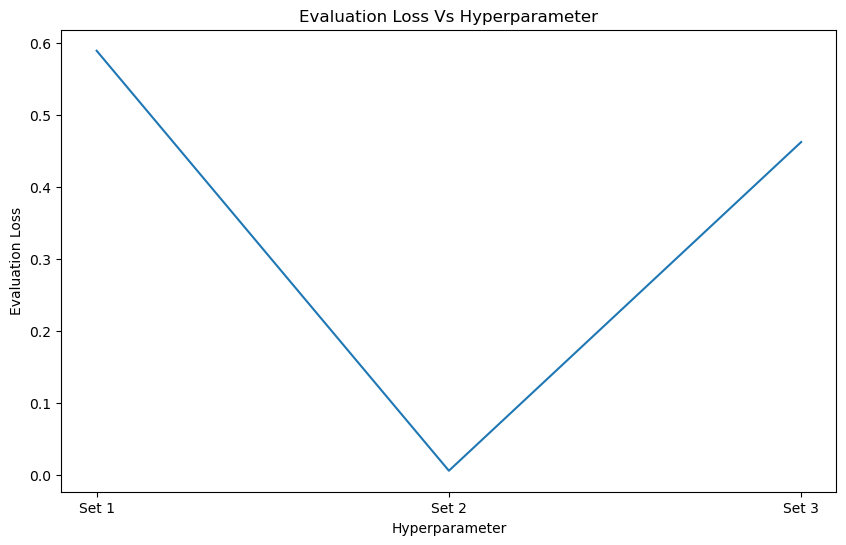

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df.index, results_df['eval_loss'])
ax.set_title('Evaluation Loss Vs Hyperparameter')
ax.set_xlabel('Hyperparameter')
ax.set_ylabel('Evaluation Loss')
ax.set_xticks(results_df.index)
ax.set_xticklabels([f"Set {i + 1}" for i in results_df.index])
plt.show()